# 2つのガウス分布を含む混合ガウス分布のためのEMアルゴリズム

千葉工業大学 上田 隆一

(c) 2017 Ryuichi Ueda

This software is released under the MIT License, see LICENSE.

## はじめに

このコードは、2つの2次元ガウス分布を含む混合ガウス分布から生成されたデータについて、EMアルゴリズムでパラメータを求めるためのEMアルゴリズムの実装例です。

## アルゴリズムを適用される対象になるデータの生成

クラスタリングの対象となるデータを作ります。二つの2次元ガウス分布から、2:1の割合で標本抽出します。

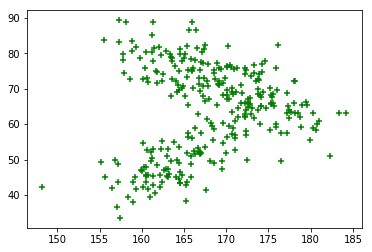

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def make_samples():
    # グループ1のガウス分布
    mu1_ans = [170,70]
    cov1_ans = [[6**2,-30],[-30,8**2]]
    samples1 = np.random.multivariate_normal(mu1_ans,cov1_ans,200).T #サンプル生成

    # グループ2のガウス分布
    mu2_ans = [165,50]
    cov2_ans = [[5.**2,20],[20,6**2]]
    samples2 = np.random.multivariate_normal(mu2_ans,cov2_ans,100).T #サンプル生成

    # 2つのグループを混ぜて返す
    return np.column_stack((samples1,samples2))

# データを作って描画
samples = make_samples()
plt.scatter(samples[0],samples[1],color='g',marker='+')

# このデータに関する既知のパラメータ
K = 2 # クラスタの数

## パラメータの初期設定

In [2]:
from scipy.stats import multivariate_normal

# 2つのガウス分布のオブジェクトを作る
distributions = []
distributions.append(multivariate_normal(mean=[0,1],cov= [[100,0],[0,100]]) )
distributions.append(multivariate_normal(mean=[1,0],cov= [[100,0],[0,100]]) )

mixing_coefs = [1.0/K for k in range(K)] #混合係数のリスト

## Eステップの実装

分布を固定し、各サンプルがどっちの分布に属すかを負担率という値で返します。

In [3]:
def draw_gauss(ds,X):
    # 分布とサンプルを描画
    x, y = np.mgrid[(min(X[0])):(max(X[0])):1, (min(X[1])):(max(X[1])):1]
    for d in ds:
        pos = np.empty(x.shape + (2,))
        pos[:, :, 0] = x; pos[:, :, 1] = y
        plt.contour(x, y, d.pdf(pos),alpha=0.2)
        
def draw(ds,X):
    draw_gauss(ds,X)
    plt.scatter(X[0],X[1],color='g',marker='+')

def expectation_step(ds,X,pis):    # 負担率の計算
    ans = [] # 負担率のリスト
    for n in range(len(X[0])): # サンプルの数（X座標の数X[0]でカウント）だけ繰り返し
        # サンプルの地点における各分布の値（密度）を計算
        ws = [ pis[k] * ds[k].pdf([X[0][n],X[1][n]]) for k in range(len(ds)) ] 
        ans.append([ws[k]/sum(ws) for k in range(K)])

    return ans

### とりあえず1回Eステップを実行

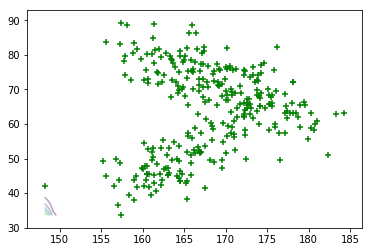

In [4]:
gammas = expectation_step(distributions,samples,mixing_coefs)
draw(distributions,samples)

## Mステップの実装

In [5]:
N = len(samples[0])

def maximization_step(k,X,gammas): 
    N_k = sum ( [ gammas[n][k] for n in range(N) ])
    tmp_x = sum ( [ gammas[n][k] * X[0][n] for n in range(N) ]) / N_k
    tmp_y = sum ( [ gammas[n][k] * X[1][n] for n in range(N) ]) / N_k

    mu = [tmp_x,tmp_y]

    sigma = np.array([[0.0,0.0],[0.0,0.0]])
    for n in range(N):
        x = np.array([X[0][n],X[1][n]])
        d = (np.array([[X[0][n],X[1][n]]]) - np.array([mu])).T
        sigma += gammas[n][k] / N_k * d.dot(d.T)

    return multivariate_normal(mean=mu,cov=sigma), N_k/N

### とりあえず1回Mステップを実行

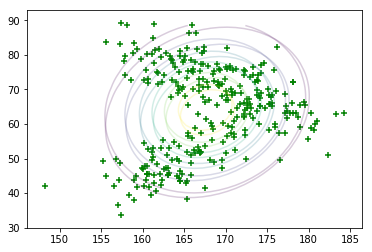

In [6]:
for k in range(K):
    distributions[k], mixing_coefs[k] = maximization_step(k,samples,gammas)
    
draw(distributions,samples)

## あと99回繰り返してみます

[0.26243139030349827, 0.73756860969650151]
[0.57241302810558703, 0.42758697189441297]
[0.6524346028369129, 0.34756539716308671]
[0.6579622077985311, 0.34203779220146907]
[0.65823558421929063, 0.34176441578070965]
[0.65824872300185777, 0.34175127699814212]
[0.65824935360714076, 0.34175064639286007]
[0.65824938387151699, 0.34175061612848268]
[0.6582493853239797, 0.34175061467602014]
[0.65824938539368361, 0.34175061460631645]
[0.65824938539688638, 0.34175061460311357]


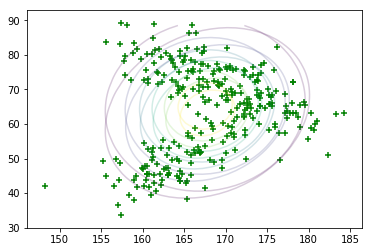

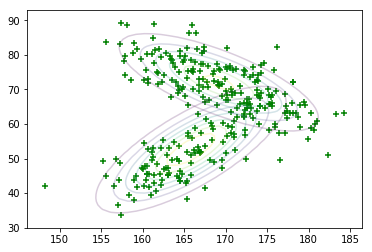

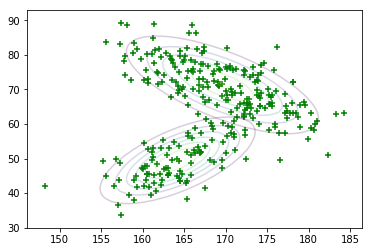

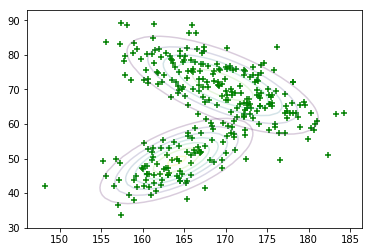

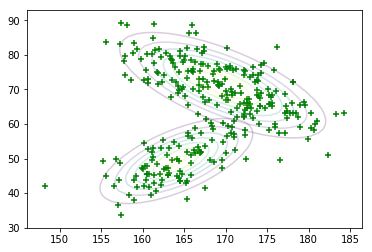

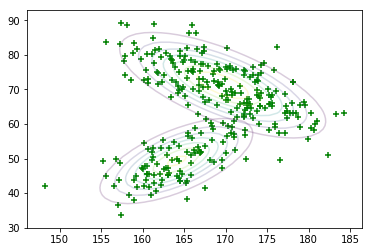

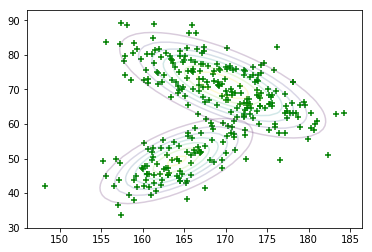

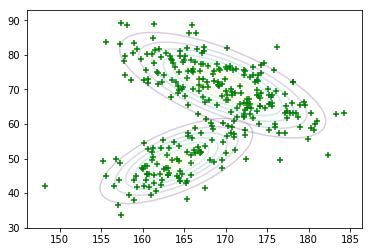

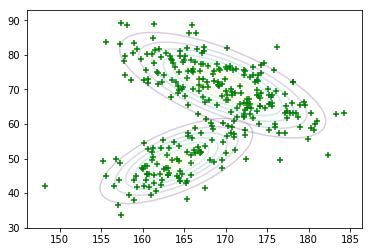

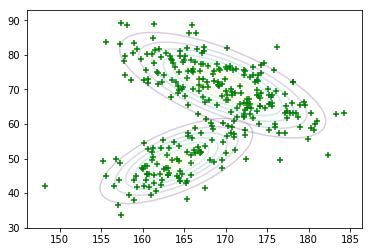

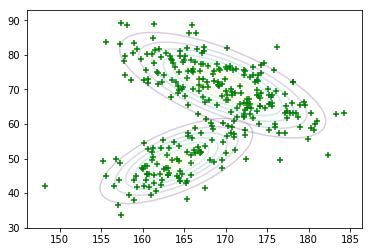

In [7]:
def one_step():
    gammas = expectation_step(distributions,samples,mixing_coefs)
    
    for k in range(K):
        distributions[k], mixing_coefs[k] = maximization_step(k,samples,gammas)

for i in range(99):
    one_step()
    
    if i %10 == 0:
        plt.figure()
        draw(distributions,samples)
        print(mixing_coefs)
        
plt.figure()
draw(distributions,samples)
print(mixing_coefs)